This script is used to calculate the clip score for FSW images (References) and generated images (Candidates).

In [1]:
# imports and libraries
import numpy as np

from tqdm import tqdm
from pathlib import Path
from PIL import Image, ImageDraw
from IPython.display import display, clear_output
from signwriting.visualizer.visualize import signwriting_to_image
from signwriting_evaluation.metrics.clip import SignWritingCLIPScore, signwriting_to_clip_image

In [2]:
# helper function

def create_side_by_side_comparison(reference_image, candidate_image, score, ref_stem, cand_key):
    side_by_side = Image.new('RGB', (reference_image.width * 2, reference_image.height), (255, 255, 255))
    
    side_by_side.paste(reference_image, (0, 0))
    side_by_side.paste(candidate_image, (reference_image.width, 0))
    
    draw = ImageDraw.Draw(side_by_side)
    draw.text((0, 0), f"{score:.3f}", fill=(255, 0, 0))
    draw.text((0, 20), f"Ref: {ref_stem}", fill=(255, 0, 0))
    draw.text((reference_image.width, 0), f"Cand: {cand_key}", fill=(255, 0, 0))
    
    return side_by_side


def manual_review(reference_img, candidate_img, score, ref_stem, cand_key):
    while True:
        clear_output(wait=True)
        side_by_side = create_side_by_side_comparison(
            reference_img,
            candidate_img,
            score,
            ref_stem,
            cand_key
        )
        display(side_by_side)
        
        response = input("Accept this match? (y/n): ").lower()
        if response in ['y', 'n']:
            return response == 'y'
        print("Please enter 'y' or 'n'")

In [3]:
# load image functions

def load_candidate_images(directory: Path):
    images = {}
    for image in tqdm(list(directory.glob('*.png'))):
        try:
            # binarization 
            img = Image.open(image).convert('L')
            img = img.point(lambda x: 255 if x > 127 else 0, '1')
            img = img.convert('L')
            images[image.stem] = img
        except Exception as e:
            print(f"Error processing {image}: {e}")
    return images


def load_gold_images(directory: Path):
    target_size = (256, 256)
    images = {}
    for image in tqdm(list(directory.glob('*.png'))):
        try:
            img = Image.open(image).convert('RGBA')
            
            # scale down the image
            scale_factor = 0.42
            max_dimension = max(img.width, img.height)
            scale = (target_size[0] * scale_factor) / max_dimension
            new_size = (int(img.width * scale), int(img.height * scale))
            img = img.resize(new_size, Image.LANCZOS)
            
            # create white background and center the image
            background = Image.new('RGBA', target_size, (255, 255, 255, 255))
            offset = ((target_size[0] - new_size[0]) // 2, 
                     (target_size[1] - new_size[1]) // 2)
            background.paste(img, offset, img)
            
            array = np.array(background)
            array[array < 170] = 0
            array[array >= 170] = 255
            
            images[image.stem] = Image.fromarray(array)
        except Exception as e:
            print(f"Error processing {image}: {e}")
    return images

Loading candidates...


100%|██████████| 2863/2863 [00:06<00:00, 456.25it/s]


Loading references...


 72%|███████▏  | 2308/3192 [00:07<00:02, 299.45it/s]

Error processing glossen\06533.png: cannot identify image file 'C:\\Users\\sarah\\Desktop\\Thesis\\signwriting-illustration\\datasets\\Vokabeltrainer\\glossen\\06533.png'


100%|██████████| 3192/3192 [00:09<00:00, 319.44it/s]

Error processing glossen\09372.png: cannot identify image file 'C:\\Users\\sarah\\Desktop\\Thesis\\signwriting-illustration\\datasets\\Vokabeltrainer\\glossen\\09372.png'
Candidates: 2863
References: 3190

Example loaded images:

Reference 1:
  Key: 00001
  Image mode: RGBA
  Image size: (256, 256)
  Unique pixel values: [  0 255]


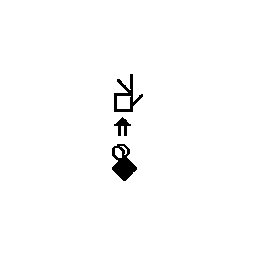


Reference 2:
  Key: 00004
  Image mode: RGBA
  Image size: (256, 256)
  Unique pixel values: [  0 255]


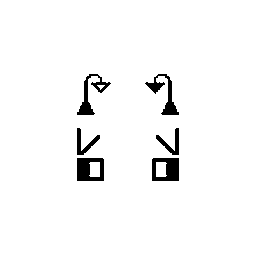


Reference 3:
  Key: 00006
  Image mode: RGBA
  Image size: (256, 256)
  Unique pixel values: [  0 255]


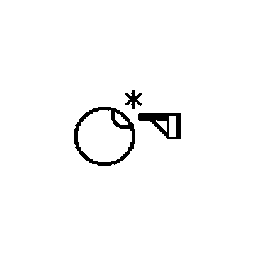


Example candidate images:

Candidate 1:
  Key: 003074d3897bbb36750a04ab4c4415b1
  Image mode: L
  Image size: (256, 256)
  Unique pixel values: [  0 255]


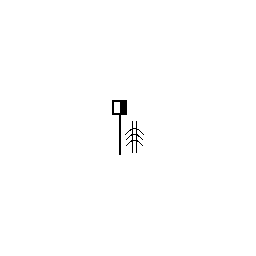


Candidate 2:
  Key: 0031d7f23b834952f58ceb4449a06dd3
  Image mode: L
  Image size: (256, 256)
  Unique pixel values: [  0 255]


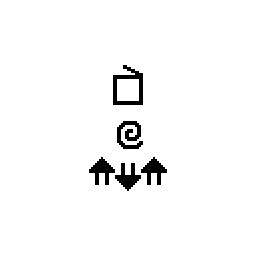


Candidate 3:
  Key: 004da87e4a1b99f87ce72ea54f8cd291
  Image mode: L
  Image size: (256, 256)
  Unique pixel values: [  0 255]


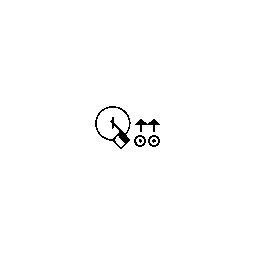

In [4]:
# load images

candidate_directory = Path("../../train/B")
reference_directory = Path("glossen")

print("Loading candidates...")
candidates = load_candidate_images(candidate_directory)
print("Loading references...")
references = load_gold_images(reference_directory)

print("Candidates:", len(candidates))
print("References:", len(references))

# 3 example outputs for loaded images
print("\nExample loaded images:")
for i, (key, img) in enumerate(list(references.items())[:3]):
    print(f"\nReference {i+1}:")
    print(f"  Key: {key}")
    print(f"  Image mode: {img.mode}")
    print(f"  Image size: {img.size}")
    print(f"  Unique pixel values: {np.unique(np.array(img))}")
    display(img)

print("\nExample candidate images:")
for i, (key, img) in enumerate(list(candidates.items())[:3]):
    print(f"\nCandidate {i+1}:")
    print(f"  Key: {key}")
    print(f"  Image mode: {img.mode}")
    print(f"  Image size: {img.size}")
    print(f"  Unique pixel values: {np.unique(np.array(img))}")
    display(img)

In [5]:
def signwriting_to_clip_image(img):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # correct sizing for CLIP
    if img.size != (224, 224):
        img = img.resize((224, 224))
    
    return img

# initialize clip score
clip_score = SignWritingCLIPScore()
candidate_keys = list(candidates.keys())

print("Processing candidate images...")
candidate_images = [signwriting_to_clip_image(img) for img in tqdm(candidates.values())]
print("Processing reference images...")
reference_images = [signwriting_to_clip_image(img) for img in tqdm(references.values())]

print("\nCalculating CLIP scores...")
all_scores = clip_score.score_all(reference_images, candidate_images)

c:\Users\sarah\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Using cache directory: C:\Users\sarah\AppData\Local\Temp/clip_cache
Processing candidate images...


100%|██████████| 2863/2863 [00:05<00:00, 545.12it/s]


Processing reference images...


100%|██████████| 3190/3190 [00:06<00:00, 506.88it/s]



Calculating CLIP scores...


Loading features cache: 100%|██████████| 2863/2863 [00:02<00:00, 1212.40it/s]


In [6]:
# main comparison loop

matches_dir = Path("score_matches")
matches_dir.mkdir(parents=True, exist_ok=True)

for i, (stem, scores) in tqdm(list(enumerate(zip(references.keys(), all_scores)))):
    argmax = np.argmax(scores)
    best_score = scores[argmax]
    
    # perfect match indicates empty image, skip
    if best_score > 0.99:
        if np.all(np.array(signwriting_to_clip_image(reference_images[i])) == 255):
            continue
    
    side_by_side = create_side_by_side_comparison(
        references[stem],
        candidates[candidate_keys[argmax]],
        best_score,
        stem,
        candidate_keys[argmax]
    )
    side_by_side.save(matches_dir / f"{stem}_comparison.png")

100%|██████████| 3190/3190 [00:34<00:00, 91.49it/s] 


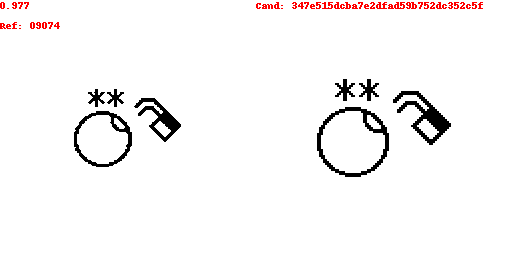

 98%|█████████▊| 3124/3190 [14:21<00:05, 11.89it/s]

Manually accepted match for 09074


100%|██████████| 3190/3190 [14:22<00:00,  3.70it/s]

Total matches found: 2797
Total manual reviews: 298


In [7]:
# final matching loop 

matches_dir = Path("matches")
matches_dir.mkdir(parents=True, exist_ok=True)

has_matches = 0
manual_reviews = 0

for i, (stem, reference) in enumerate(tqdm(list(references.items()), position=0, leave=True)):
    scores = all_scores[i] 
    best_score_idx = np.argmax(scores)
    best_score = scores[best_score_idx]
    
    # perfect match indicates empty image, skip
    if best_score > 0.99:
        if np.all(np.array(signwriting_to_clip_image(reference)) == 255):
            continue
    
    save_match = False        
    if 0.97 <= best_score < 0.98:  # manual review range
        manual_reviews += 1
        best_candidate_key = candidate_keys[best_score_idx]
        best_candidate = candidates[best_candidate_key]
        
        review_result = manual_review(reference, best_candidate, best_score, stem, best_candidate_key)
        if review_result:
            save_match = True
            has_matches += 1
            print(f"Manually accepted match for {stem}")
    elif best_score > 0.93:  # automatic acceptance threshold
        save_match = True
        has_matches += 1
    
    if save_match:
        best_candidate_key = candidate_keys[best_score_idx]
        best_candidate = candidates[best_candidate_key]
        
        side_by_side = create_side_by_side_comparison(
            reference,
            best_candidate,
            best_score,
            stem,
            best_candidate_key
        )
        side_by_side.save(matches_dir / f"{stem}.png")

print(f"Total matches found: {has_matches}")
print(f"Total manual reviews: {manual_reviews}")